# Classification of power spectra with BaCoN

Arnav Agarwal\
S2163065

Working on the inclusion of the dark scattering theory into the existing BaCoN-II 5-label model.

## Load the code

Here we import the github repository and import BaCoN.

Tensorflow2 and Tensorflow2 Probability should be installed.

In [2]:
!git clone https://github.com/arnava13/SeniorHonoursProject
%cd SeniorHonoursProject/BaCoN-II

/content/SeniorHonoursProject/BaCoN-II


## Run training in shell
only do this when not loading trained network

In [4]:
!pip install -q lib5c
!lib5c -v
!pip install tensorflow==2.15.0
!pip install tensorflow-probability==0.23.0

lib5c version 0.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1


In [3]:
import os;
import subprocess
import threading
import argparse
from test import *
from utils import *
from models import *
from data_generator import *
from train import *

In [ ]:
from importer import load_model_for_test, my_predict, predict_bayes_label, predict_mean_proba

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'serif'
plt.rcParams["mathtext.fontset"] = "cm"

In [ ]:
def handle_output(stream, prefix, log_file):
    for line in iter(stream.readline, b''):  # This iterates over the output line by line
        my_bytes = line.strip()
        if my_bytes:
            output = f"{prefix}: {my_bytes.decode('utf-8')}"
            print(output)
            log_file.write(output + "\n")

### set parameters for training

In [ ]:
# Training options:

# ------------------ change the training directory and model name here ------------------

# training data directory path
DIR='data/ds_ee2_train_1k_equal_examples_rands'
## (batch size, is a multiple of #classes * noise realisations, e.g. 5 classes, 10 noise --> must be multiple of 50)
batch_size='3000'

# training the network
GPU='True' # Use GPUs in training?
TPU='False' # Train with TPUs?
# which kind of model
bayesian='True' # Bayesian NN or traditional NN (weights single valued or distributions?)
n_epochs='50' # How many epochs to train for?


# ------------------ ignore all the other parameters for now ------------------

# Directories
mypath=None # Parent directory

# Edit this with base model directory
mdir='models/'

# normalisation file
norm_data_name = '/planck_ee2.txt'

# scale cut and resolution
k_max='5.0' # max of k-modes to include?
k_min='0.431788' # min of k-modes to include?
sample_pace='4'

# should the processed curves be saved in an extra file (False recommended, only efficient for n_epochs = 1)
save_processed_spectra='False'

# -------------------- noise model --------------------

# noise model - Cosmic variance and shot noise are Euclid-like
n_noisy_samples='10' # How many noise examples to train on?
add_noise='True'# Add noise?
add_shot='False'# Add shot noise term? -- default should be False
add_sys='True'# Add systematic error term?
add_cosvar='True'# Add cosmic variance term?

# path to folder with theory error curves
curves_folder = 'data/curve_files_sys/theory_error'; sigma_curves_default = '0.05'
# change rescale distribution of theory error curves, uniform recommended
rescale_curves = 'uniform' # or gaussian or None

# sys error curves - relative scale of curve-amplitude
sigma_curves='0.05'



# -------------------- additional training settings --------------------


# Type of model
model_name='custom' # Custom or dummy - dummy has presets as given in models.py

# fine-tune = only 'LCDM' and 'non-LCDM'
fine_tune='False' # Model trained to distinguish between 'LCDM' and 'non-LCDM' classes or between all clases. i.e. binary or multi-classifier

#Test mode?
test_mode='False' # Network trained on 1 batch of minimal size or not?
seed='1312' # Initial seed for test mode batch
# Saving or restoring training
restore='False' # Restore training from a checkpoint?
save_ckpt='True' # Save checkpoints?


val_size='0.15' # Validation set % of data set

add_FT_dense='False' #if True, adds an additional dense layer before the final 2D one

patience='50' # terminate training after 'patience' epochs if no decrease in loss function
lr='0.01' # learning rate
decay='0.95' #decay rate: If None : Adam(lr),

# ----------------- Model Name Generation -------------

#Two or Six label?
if fine_tune != 'True':
  two_or_six = 'sixlabel'
else:
  two_or_six = 'twolabel'

#Examples Per Class?
ds_class_dir = os.path.join(DIR,"ds")
examples_per_class = len([entry for entry in os.listdir(ds_class_dir) if os.path.isfile(os.path.join(ds_class_dir, entry))]) - 1

#Generation code?
gen_code = "EE2"

#LCDM * Filter or Equal Examples from each class * Filter for randoms?
randstype = "equalexamples-randoms"
#randstype = "LCDM-randoms"

#Additional Notes?
fname_notes = ""

#Assemble fname
fname = f"{two_or_six}_{examples_per_class}_{gen_code}_{randstype}_kmin-{k_min}_kmax-{k_max}_{fname_notes}"

# -------------------- BNN parameters -----------------

# Example image details
im_depth='500' # Number in z direction (e.g. 500 wave modes for P(k) examples)
im_width='1' # Number in y direction (1 is a 2D image : P(k,mu))
im_channels='4'  # Number in x direction (e.g. 4 redshifts for P(k,z))
swap_axes='True' # Do we swap depth and width axes? True if we have 1D image in 4 channels
sort_labels='True' # Sorts labels in ascending/alphabetical order

z1='0' # which z-bins to include? Assumes each channel is a new z bin.
z2='1' # which z-bins to include? Assumes each channel is a new z bin.
z3='2' # which z-bins to include? Assumes each channel is a new z bin.
z4='3' # which z-bins to include? Assumes each channel is a new z bin.

# Number of layers and kernel sizes
k1='10'
k2='5'
k3='2'
 # The dimensionality of the output space (i.e. the number of filters in the convolution)
f1='8'
f2='16'
f3='32'
 # Stride of each layer's kernel
s1='2'
s2='2'
s3='1'
# Pooling layer sizes
p1='2'
p2='2'
p3='0'
# Strides in Pooling layer
sp1='2'
sp2='1'
sp3='0'

n_dense='1' # Number of dense layers

# labels of different cosmologies
#c0_label = 'lcdm'
#c1_label = 'fR dgp wcdm'

log_path = mdir + fname + '_log'

if fine_tune == "True":
    log_path += '_FT'

log_path += '.txt'




### run the training
this may take a while to run, also expect some (harmless) error messages in the output

In [ ]:
# -------------- training loads parameters entered above  --------------
proc = subprocess.Popen(["python3", "train.py", "--test_mode" , test_mode, "--seed", seed, \
                     "--bayesian", bayesian, "--model_name", model_name, \
                     "--fine_tune", fine_tune, "--log_path", log_path,\
                     "--restore", restore, \
                     "--models_dir", mdir, \
                     "--fname", fname, \
                     "--DIR", DIR, \
                     '--norm_data_name', norm_data_name, \
                     '--curves_folder', curves_folder,\
                     "--c_0", 'lcdm', \
                     "--c_1", 'fR', 'dgp', 'wcdm', 'ds', 'rand'\
                     "--save_ckpt", save_ckpt, \
                     "--im_depth", im_depth, "--im_width", im_width, "--im_channels", im_channels, \
                     "--swap_axes", swap_axes, \
                     "--sort_labels", sort_labels, \
                     "--add_noise", add_noise, "--add_shot", add_shot, "--add_sys", add_sys,"--add_cosvar", add_cosvar, \
                     "--sigma_curves", sigma_curves, \
                     "--sigma_curves_default", sigma_curves_default, \
                     "--save_processed_spectra", save_processed_spectra, \
                     "--sample_pace", sample_pace,\
                     "--n_noisy_samples", n_noisy_samples, \
                     "--rescale_curves", rescale_curves, \
                     "--val_size", val_size, \
                     "--z_bins", z1,z2,z3,z4, \
                     "--filters", f1,f2,f3, "--kernel_sizes", k1,k2,k3, "--strides", s1,s2,s3, "--pool_sizes", p1,p2,p3, "--strides_pooling", sp1,sp2,sp3, \
                     "--k_max", k_max,\
                     "--k_min", k_min,\
                     "--n_dense", n_dense,\
                     "--add_FT_dense", add_FT_dense, \
                     "--n_epochs", n_epochs, "--patience", patience, "--batch_size", batch_size, "--lr", lr, \
                     "--decay", decay, \
                     "--GPU", GPU],\
                     stdout=subprocess.PIPE, \
                     stderr=subprocess.PIPE)

with open(log_path, "w") as log_file:

    stdout_thread = threading.Thread(target=handle_output, args=(proc.stdout, "out", log_file))
    stderr_thread = threading.Thread(target=handle_output, args=(proc.stderr, "err", log_file))

    stdout_thread.start()
    stderr_thread.start()

    stdout_thread.join()
    stderr_thread.join()

    proc.wait()

In [ ]:
ls models/

EE2_train20k_baseline/                    model_withBayes_GPU_train_1k/
model_withBayes_GPU_train_100/            model_withBayes_GPU_train_1k_log_FT.txt
model_withBayes_GPU_train_100_log_FT.txt


## Run the test of the model
- insert the path+name of the log file of the model
- change the test directory
- change the custom name that will be used for the confusion matrix

The pdf file with the confusion matrix is saved in the model folder.

In [ ]:
!python test.py --log_path='models/sixlabel_1000_EE2_LCDM-randoms_kmin-0.0_kmax-5.0_/sixlabel_1000_EE2_LCDM-randoms_kmin-0.0_kmax-5.0__log.txt' \
  --TEST_DIR='data/ds_ee2_test_1k_lcdm_rands' --cm_name_custom='sixlabel_1000_EE2_LCDM-randoms_kmin-0.0_kmax-5.0_'

2024-03-03 21:37:00.751545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 21:37:00.751589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 21:37:00.752858: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 21:37:01.727420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Reading log from models/sixlabel_1000_EE2_LCDM-randoms_kmin-0.0_kmax-5.0_/sixlabel_1000_EE2_LCDM-randoms_kmin-0.0_kmax-5.0__log.txt 
The following line has not been formatted: 
 group_lab_dict {'True': 'non_lcdm', 'dgp': 'non_lcdm', 'ds': 'n

## Load modules for classification of a single spectrum

### Functions to load trained models and data
just execute the following cells

In [ ]:
def read_pre_trained_flags(args_dict):
  '''
  Read model options from logfile and return them in the form of FLAGS (the corresponding class is in utils)
  '''
  args = DummyFlags(args_dict)
  FLAGS = get_flags(args.log_path)
  if args.models_dir is not None:
        print('Reading model from the directory %s' %args.models_dir)
        FLAGS.models_dir = args.models_dir
  return FLAGS


def get_pre_trained_model(fname, n_classes, input_shape):
  '''
  returns pre-trained model.
  Input:  - fname: string, folder where the trained model is stored
          - n_classes: integer, number of output classes of the model
          - input_shape:  tuple, input dimensions of the model.
                          For pre-trained model in the paper use (100, 4)

  '''

  log_path = os.path.join('models', fname, fname+'_log.txt' )
  models_dir = os.path.join('models', fname)

  args_dict= {'log_path':log_path, 'models_dir': models_dir, }
  FLAGS=read_pre_trained_flags(args_dict)

  print('Input shape %s' %str(input_shape))


  model_loaded =  load_model_for_test(FLAGS, input_shape, n_classes=n_classes,
                                        generator=None, new_fname='')


  return model_loaded



def load_X(fname, sample_pace, i_max, norm_data,
           add_noise=True, normalise=True, use_sample_pace=False, include_k=True):
  '''
  Generates one power spectrum X ready for classification.
  Options:  fname: path to data
            sample_pace: read one point every sample_pace. Useful to reduce data dimension
            i_max: Index corresponding to the max k used
            norm_data: normalization spectrum

            add_noise: whether to add noise or not
            normalise: normalise by Planck or not
            use_sample_pace
            include_k: return k, X or only X



  '''

  all = np.loadtxt(fname)
  print('loaded data shape: %s' %str(all.shape))
  if include_k:
    k, X = all[:, 0], all[:, 1:]
    print('k, X  shape: %s, %s' %(str(k.shape), str(X.shape)))
  else:
    X = all
    k=np.arange(X.shape[0])
    print('X  shape : %s' %( str(X.shape)))
  if use_sample_pace:
    k, X = k[::sample_pace], X[::sample_pace]
  print('X  shape after sample pace:  %s' %( str(X.shape)))
  k, X  = k[:i_max], X[:i_max]
  print('X  shape after k max: %s' %( str(X.shape)))
  if add_noise:
    noise = np.random.normal(loc=0, scale=generate_noise(k,X, add_sys=True,add_shot=True,sigma_sys=5 ))
    X = X+noise
  if normalise:
    planck = norm_data
    print('planck data shape: %s' %str(planck.shape))
    X = X/planck-1
  if include_k:
    return k, X
  else:
    return X

## Code for getting confidence

In [ ]:
def sample_from_data(model,  my_Xs_norm,  my_min=np.zeros(5), my_max=np.ones(5),
                     n_samples=50000, num_monte_carlo=100, th_prob=0.5,
                     verbose=True):
  '''
  Given some normalized features my_Xs_norm and the model, compute mu and Sigma as in the paper eq. 2.8-2.9
  and return samples from the probability distribuion eq. 2.10
  '''
  Al_error, Ep_error, mean = get_mu_Sigma(model, my_Xs_norm , num_monte_carlo=num_monte_carlo, th_prob=th_prob, verbose=verbose)
  Sigma = (Al_error+ Ep_error).numpy()
  MM = mean.numpy()
  if verbose:
    print('Sigma')
    print(np.round(Sigma, 3))
  samples, z_samples = sample_probas(Sigma, MM, my_min=my_min,my_max=my_max, n_samples=n_samples, verbose=verbose)

  return samples, z_samples, Sigma, MM



def get_mu_Sigma(model, my_Xs_norm, num_monte_carlo=100, th_prob=0.5, verbose=True):
  ''''
  Given some normalized features my_Xs_norm and the model, compute mu and Sigma as in the paper eq. 2.8-2.9
  '''
  if verbose:
    print('Computing mu and sigma...')
  sampled_probas, _, _ = my_predict(tf.expand_dims(my_Xs_norm, axis=0), model, num_monte_carlo=num_monte_carlo, th_prob=th_prob)
  mean = tf.reduce_mean(sampled_probas[:,0,:], axis=0)
  _, Al_error, Ep_error = get_err_variances(sampled_probas[:,0,:])
  return Al_error, Ep_error, mean


def sample_probas(Sigma, MM, my_min=np.zeros(5), my_max=np.ones(5), n_samples=50000, verbose=True):
  '''
  Given mu and Sigma as in the paper eq. 2.8-2.9, computes B, U as described in appendix B of the paper.
  Then calls function to sample the prob. distribution (eq. 2.10)
  '''
  if verbose:
    print('Sample probas call')
  evals, evecs = np.linalg.eig(Sigma)
  B = evecs
  U = B.T @ Sigma @  B
  if verbose:
    print('U')
    print(np.round(U, 3))
  n_dims=U.shape[0]-1
  n_dims=U.shape[0]-1
  ind_min = np.argmin(np.diag(U))
  if verbose:
    print('Index of min eigenvalue is: %s' %ind_min)
    print('Min eigenvalue is: %s' %np.min(np.diag(U)))
  UU = np.array([np.sqrt(U[i,i])  for i in range(U.shape[0]) if i!=ind_min ] )
  if verbose:
    print('U has %s elements ' %str(UU.shape[0]))
  samples, z_samples = get_samples(UU, B, MM, my_min=my_min, my_max=my_max, ind_min=ind_min, n_dims=n_dims, n_samples=n_samples, verbose=verbose)
  return samples, z_samples


def get_samples(UU, B, MM, my_min=np.zeros(5), my_max=np.ones(5), ind_min=-1, n_dims=4, n_samples=50000, verbose=True):
  '''
  samples eq. 2.10 as described in appendix B
  '''
  if verbose:
    print('Sampling...')
  samples = np.zeros((0, n_dims+1))
  z_samples = np.zeros((0, n_dims))
  while samples.shape[0] < n_samples:
    s = np.random.multivariate_normal( np.zeros(n_dims), np.diag(UU**2), size=(n_samples,))
    accepted = s[(np.min(X_val_batch(s, B, MM, null_ind=ind_min)-my_min, axis=1) >= 0) & (np.max(X_val_batch(s, B, MM, null_ind=ind_min) - my_max, axis=1) <= 0)]
    samples = np.concatenate((samples, X_val_batch(accepted, B, MM, null_ind=ind_min)), axis=0)
    z_samples = np.concatenate((z_samples, accepted), axis=0)
  samples = samples[:n_samples, :]
  z_samples = z_samples[:n_samples, :]
  if verbose:
    print('Done.')
  return samples, z_samples



def X_val_batch(Z, B, MM, null_ind):
  return np.array([ X_val(Z[i], B, MM, null_ind=null_ind,) for i in range(Z.shape[0])])

def Z(X, B, MM):
  '''  X must be 5-d '''
  return B.T @ (X-MM)

def X_val(Z, B, MM, null_ind=-1, verbose=False):
  '''  Z must be 4-d , MM must be 5-d '''
  if verbose:
    print(Z)
  Z = np.insert(Z, null_ind, 0)
  if verbose:
    print(Z)
  return B @ Z+ MM


def get_err_variances(prob_k, AlEp_split=True):
  '''
  Computes aleatoric and epistemic uncertainty from MC samples from the net. weights
  '''
  num_samples = prob_k.shape[0]
  prob_mean = tf.reduce_mean(prob_k, axis=0)

  diag_probs = tf.stack([np.diag(prob_k[i,:]) for i in range(num_samples)], axis=0)  # Diagonal matrix whose diagonal elements are the output of the network for the ith sample
  outer_products_Al = tf.stack([tf.tensordot(prob_k[i,:], prob_k[i,:], axes =0) for i in range(num_samples)], axis=0) # Outer self-product of the predictive vectors for the ith sample used in computing Al uncertainty
  outer_products_Ep = tf.stack([tf.tensordot(prob_k[i,:] - prob_mean, prob_k[i,:] - prob_mean, axes =0) for i in range(num_samples)], axis=0) # Outer self-product between the difference of the predictive vector for ith sampl and average prediction

  Al_error = tf.reduce_mean(diag_probs - outer_products_Al, axis=0) # Average over all the samples to compute aleotoric uncertainty
  Ep_error = tf.reduce_mean(outer_products_Ep, axis=0) # Average over all the samples to compute epistemic uncertainty

  tot_error = Al_error + Ep_error # Combine to compute total uncertainty
  confidences = tf.linalg.diag_part(tot_error).numpy()

  if AlEp_split:
    return confidences, Al_error, Ep_error
  else:
    return confidences



def get_P_from_samples(samples, th_prob=0.5 ):
  '''
  Given samples from eq. 2.10, computes the probabilities as in eq. 2.11
  '''
  Ntot = samples.shape[0] #-unclassified
  n_dims  = samples.shape[-1]
  all_preds = np.array([predict_bayes_label(sample, th_prob=th_prob) for sample in samples])
  unclassified=all_preds[all_preds==99].shape[0]

  n_in_class = np.array([all_preds[all_preds==k].shape[0] for k in range(n_dims)])

  #print('Ntot: %s  ' %Ntot)
  p_uncl=unclassified/Ntot
  #print('%s unclassified examples ' %unclassified)
  #print('P(unclassified)=%s ' %p_uncl)
  pp=n_in_class/Ntot
  #print(pp)
  #print(p_uncl)

  return np.append(pp, p_uncl)


def get_all_probas(X, model_loaded,
                   n_classes=5,
                   num_monte_carlo=100,
                   th_prob=0.5,
                   n_samples=10000,
                   verbose=True):
    '''
    Given features X, predicts the labels with MC samples from the net,
    computes mu and sigma, samples from the prob distribution
    and computes P.
    Returns result in the form of a dictionary
    '''

    # Gaussian approx
    samples, z_samples, Sigma, MM = sample_from_data(model_loaded,
                                                 my_Xs_norm=X,
                                                 my_min=np.zeros(n_classes), my_max=np.ones(n_classes),
                                                 n_samples=n_samples,
                                                 num_monte_carlo=num_monte_carlo,
                                                 th_prob=th_prob, verbose=verbose)

    P = get_P_from_samples(samples, th_prob=th_prob)
    if verbose:
      print('P: %s ' %str(P))
      print('P sum to %s' %P.sum())
    if verbose:
      print('mu  sum to %s' %MM.sum())


    # Result
    res = {'samples':samples, 'P':P, 'z_samples': z_samples, 'Sigma': Sigma, 'MM': MM,}
    return res


def plot_hist_1D(samples, MM, th_prob=0.5,
                  P=None, inv_labels_dict=None,):
  '''
  Plots histogram of gauss samples for each class
  '''

  n_dims = samples.shape[-1]-1
  fig, axs = plt.subplots(1, n_dims+1, sharey=True, sharex=False,figsize=(25,5))

  t_str=''
  for k in range(n_dims+1):

    axs[k].hist(samples.T[k], bins=15, color = "lightgray",lw=0, density=True, label='Gauss samples')
    axs[k].text(0.1, 0.9, '$\mu = $' + '$'+ str(MM[k])+'$', fontsize = 16 , transform=axs[k].transAxes);
    if P is  not None:
      axs[k].text(0.1, 0.8, '$ P = $' + '$'+ str(P[k])+'$', fontsize = 16 , transform=axs[k].transAxes);
      if k==0:
        t_str+= 'P unclassified: %s \n' %str(np.round(P[-1], 2) )
    axs[k].set_xlim(0,1)
    axs[k].set_ylim(0,10)

    if inv_labels_dict is not None:
      axs[k].set_title(inv_labels_dict[k])


    axs[k].legend(loc='lower right')

  axs[0].set_ylabel('P')
  fig.suptitle(t_str)

  plt.show()

## Load models

Here we load the pre trained models

In [ ]:
# Encoding of the labels for the two networks. Can be found in the log file of the training.
# Here it is easier to define it by hand.

inv_labels_dict_6={'dgp': 0, 'ds': 1, 'fr': 2, 'lcdm': 3, 'rand': 4, 'wcdm': 5}
inv_labels_dict_2={0:'lcdm', 1:'non-LCDM'}

change the model name (first parameter) in the following function

In [ ]:
model_6 = get_pre_trained_model('ds_ee2_1k_equalweight_randoms_kmax_5', 6, (100, 4) )


 -------- Loaded parameters:
bayesian True
test_mode False
n_test_idx 2
seed 1312
fine_tune False
one_vs_all False
c_0 ['lcdm']
c_1 ['True', 'dgp', 'ds', 'fR', 'rand--save_ckpt', 'wcdm']
dataset_balanced False
include_last False
log_path 
restore False
fname ds_ee2_1k_equalweight_randoms_kmax_5
model_name custom
my_path None
DIR data/ds_ee2_train_1k
TEST_DIR data/test_data/
models_dir models/
save_ckpt True
out_path_overwrite False
curves_folder data/curve_files_sys/theory_error
save_processed_spectra False
im_depth 500
im_width 1
im_channels 4
swap_axes True
sort_labels True
norm_data_name /planck_ee2.txt
normalization stdcosmo
sample_pace 4
k_max 5.0
i_max None
add_noise True
n_noisy_samples 10
add_shot False
add_sys True
add_cosvar True
sigma_sys None
sys_scaled None
sys_factor None
sys_max None
sigma_curves 0.05
sigma_curves_default 0.05
rescale_curves uniform
z_bins [0, 1, 2, 3]
n_dense 1
filters [8, 16, 32]
kernel_sizes [10, 5, 2]
strides [2, 2, 1]
pool_sizes [2, 2, 0]
strides_p

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Expected output dimension of layer max_pooling1d_5: 9.0
Expected output dimension of layer conv1d_flipout_8: 8.0
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 4)]          0         
                                                                 
 conv1d_flipout_6 (Conv1DFl  (None, 46, 8)             648       
 ipout)                                                          
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 23, 8)             0         
 g1D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 23, 8)             32        
 chNormalization)                                                
                                                                 
 conv1d_flip

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
------------ RESTORING CHECKPOINT ------------

Looking for ckpt in models/ds_ee2_1k_equalweight_randoms_kmax_5/tf_ckpts/
Restoring checkpoint from models/ds_ee2_1k_equalweight_randoms_kmax_5/tf_ckpts/ckpt-30


## Loading a trained network and applying it to a single file

Template for loading spectra. Suppose you saved the spectrum in
'data/example_spectra/my_ex.txt' . The spectrum is in 4 redshift bins and with 100 points between 0.01 - 2.5 in k . We normalize by the reference planck spectrum and add gaussian noise, then pass it to the five-label network.

Load normalization data first

In [ ]:
sample_pace=4 # the planck data were generated with 500 points up to k=10 . We need 1 every 4 points, and to cut to k_max=5.0
i_max=200 #for kmax = 5

planck = np.loadtxt('data/normalisation/planck_ee2.txt')[:, 1:][::sample_pace][:i_max]

In [ ]:
k, X_ds = load_X('data/ds_ee2_test_1k/ds/976.txt',
                 sample_pace=sample_pace, i_max=200,
                 norm_data=planck,
                 add_noise=False, normalise=True, use_sample_pace=True)

loaded data shape: (500, 5)
k, X  shape: (500,), (500, 4)
X  shape after sample pace:  (125, 4)
X  shape after k max: (125, 4)
planck data shape: (125, 4)


Let's look at the input features as seen by the network.

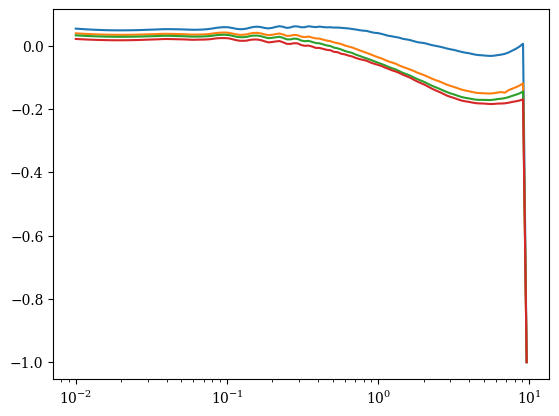

In [ ]:
plt.plot(k, X_ds);
plt.xscale('log');

## Classify your spectra and compute confidence
### (for Bayesian networks only)

In [ ]:
res_ds = get_all_probas(X_ds,
                        model_5,
                        n_classes=6,
                        num_monte_carlo=10,
                        th_prob=0.5,
                        n_samples=1000)

Computing mu and sigma...
Sigma
[[ 0.    -0.    -0.    -0.    -0.    -0.   ]
 [-0.     0.248 -0.001 -0.    -0.016 -0.232]
 [-0.    -0.001  0.001 -0.    -0.    -0.001]
 [-0.    -0.    -0.     0.    -0.    -0.   ]
 [-0.    -0.016 -0.    -0.     0.034 -0.018]
 [-0.    -0.232 -0.001 -0.    -0.018  0.25 ]]
Sample probas call
U
[[ 0.481  0.    -0.     0.     0.    -0.   ]
 [-0.     0.051  0.    -0.     0.    -0.   ]
 [-0.     0.     0.002 -0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.    -0.   ]
 [-0.     0.     0.    -0.     0.    -0.   ]
 [ 0.    -0.    -0.     0.    -0.     0.   ]]
Index of min eigenvalue is: 3
Min eigenvalue is: 1.5765484e-09
U has 5 elements 
Sampling...
Done.
P: [0.    0.352 0.    0.    0.007 0.362 0.279] 
P sum to 1.0
mu  sum to 1.0000001


P-non-LCDM=1.0


KeyError: 0

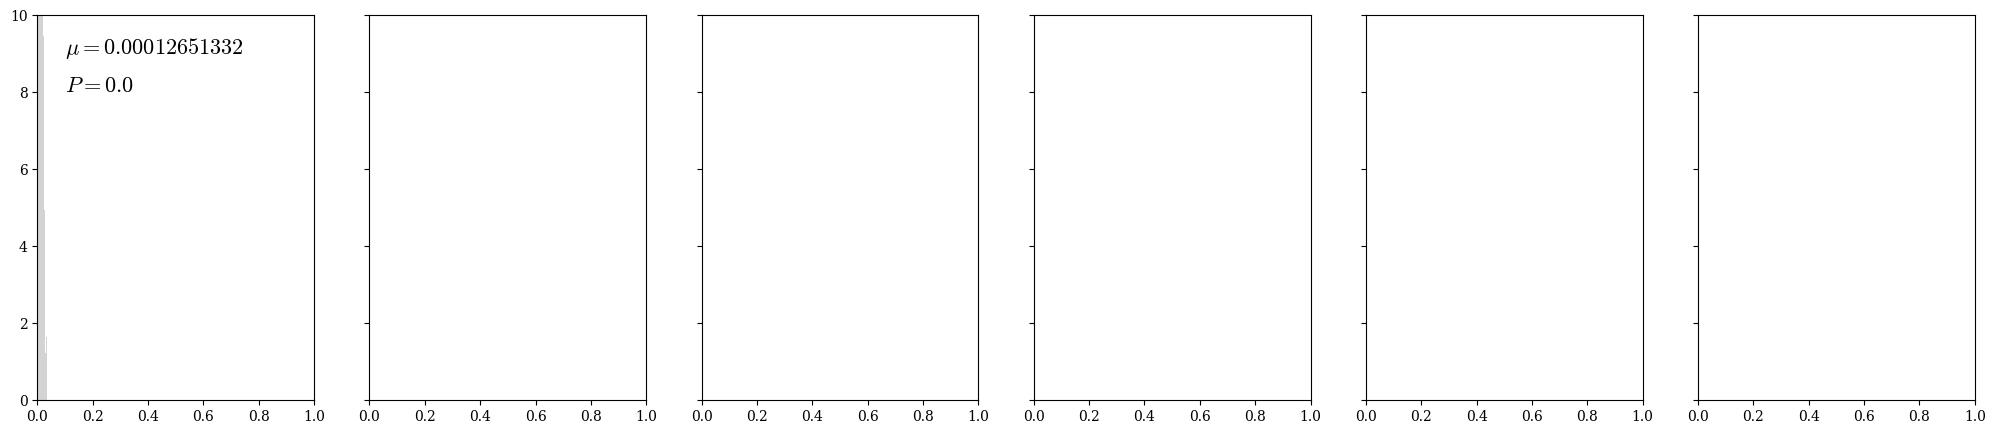

In [ ]:
print('P-non-LCDM=%s' %(np.delete(res_ds['P'], [2]).sum()))
plot_hist_1D(res_ds['samples'],
             res_ds['MM'],
             th_prob=0.5,
             P=res_ds['P'],
             inv_labels_dict=inv_labels_dict_5)
